In [168]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import datetime as dt
from datetime import datetime
import tensorflow as tf
plt.style.use('fivethirtyeight')

In [169]:
#Get the stock quote
data = yf.download('^GSPC', start='2012-01-01', end='2019-12-17')

#Show the data
# data.pop('Volume')
data.pop('Adj Close')
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,1258.859985,1284.619995,1258.859985,1277.060059,3943710000
2012-01-04,1277.030029,1278.729980,1268.099976,1277.300049,3592580000
2012-01-05,1277.300049,1283.050049,1265.260010,1281.060059,4315950000
2012-01-06,1280.930054,1281.839966,1273.339966,1277.810059,3656830000
2012-01-09,1277.829956,1281.989990,1274.550049,1280.699951,3371600000
...,...,...,...,...,...
2019-12-10,3135.360107,3142.120117,3126.090088,3132.520020,3346310000
2019-12-11,3135.750000,3143.979980,3133.209961,3141.629883,3257650000
2019-12-12,3141.229980,3176.280029,3138.469971,3168.570068,4003200000


In [170]:
datelist_train = data.index.astype(str)
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

<function matplotlib.pyplot.show(close=None, block=None)>

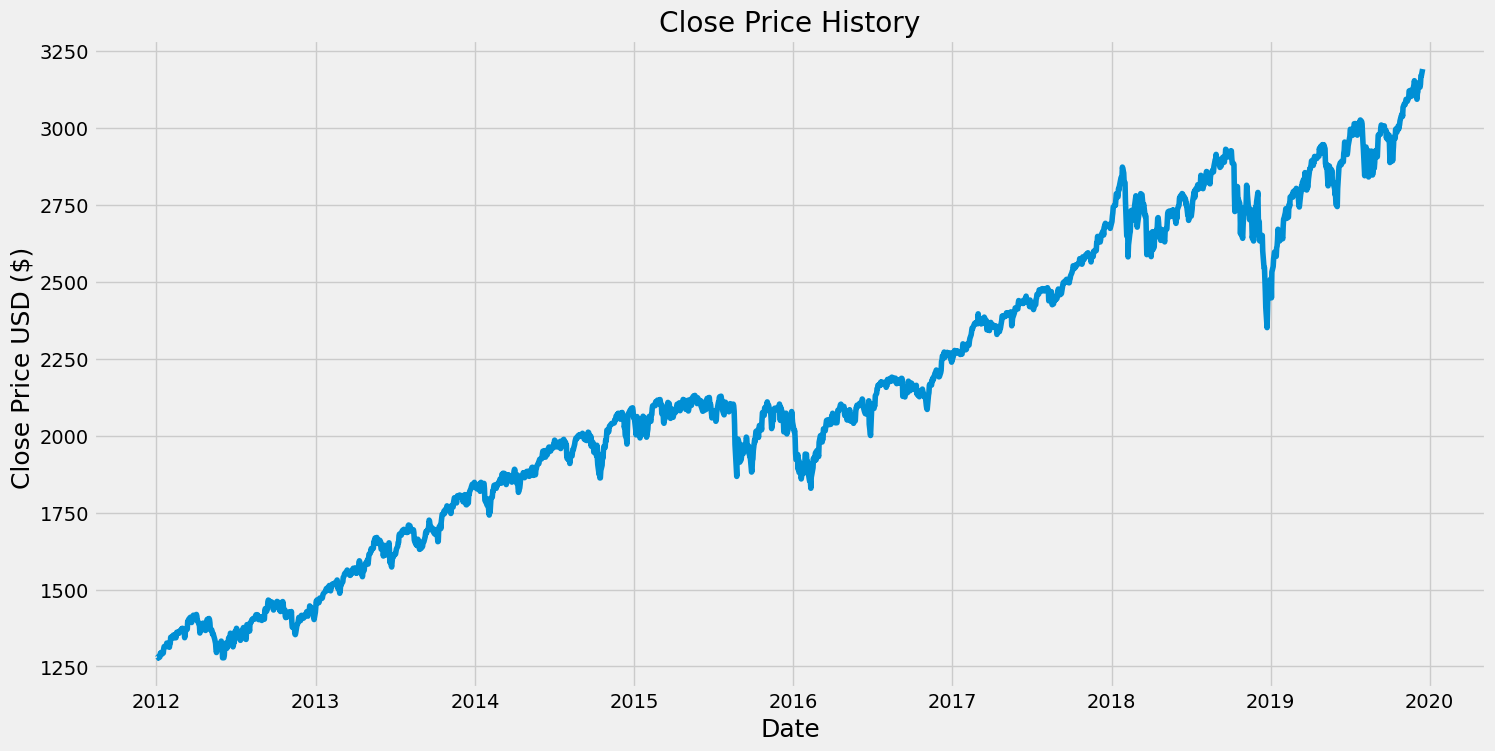

In [171]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(data['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($) ', fontsize=18)
plt.show

In [172]:
df = data.astype(float)

# Using multiple predictors (features)
df = df.values

print(df.shape)
print(df)

(2002, 5)
[[1.25885999e+03 1.28462000e+03 1.25885999e+03 1.27706006e+03
  3.94371000e+09]
 [1.27703003e+03 1.27872998e+03 1.26809998e+03 1.27730005e+03
  3.59258000e+09]
 [1.27730005e+03 1.28305005e+03 1.26526001e+03 1.28106006e+03
  4.31595000e+09]
 ...
 [3.14122998e+03 3.17628003e+03 3.13846997e+03 3.16857007e+03
  4.00320000e+09]
 [3.16664990e+03 3.18267993e+03 3.15651001e+03 3.16880005e+03
  3.75765000e+09]
 [3.18362988e+03 3.19770996e+03 3.18362988e+03 3.19144995e+03
  4.07020000e+09]]


In [173]:
#Verify the output (y) which is the 'Close' column
df[:, 3:4]

array([[1277.06005859],
       [1277.30004883],
       [1281.06005859],
       ...,
       [3168.57006836],
       [3168.80004883],
       [3191.44995117]])

In [174]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)

sc_predict = MinMaxScaler(feature_range=(0,1))
sc_predict.fit_transform(df[:, 3:4])

array([[0.00000000e+00],
       [1.25361211e-04],
       [2.08943853e-03],
       ...,
       [9.88048473e-01],
       [9.88168605e-01],
       [1.00000000e+00]])

In [175]:
#Create the training data set
#Create the scaled training data set
# train_data = scaled_data[0:training_data_len, :]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

n_future = 60 # Number of days we want to predict into the future
n_past = 90 # Number of past days we want to use to predict the future

for i in range(n_past, len(scaled_data) - n_future + 1):
    x_train.append(scaled_data[i - n_past:i, 0:data.shape[1] - 1])
    y_train.append(scaled_data[i : i + n_future, 3:4])
    if i<= n_past:
        print(x_train)
        print(y_train)
        print()

[array([[0.        , 0.00306935, 0.        , 0.        ],
       [0.00944011, 0.        , 0.00480057, 0.00012536],
       [0.0095804 , 0.00225123, 0.00332509, 0.00208944],
       [0.01146634, 0.00162065, 0.00752297, 0.00039177],
       [0.00985571, 0.00169882, 0.00815166, 0.00190133],
       [0.0113832 , 0.00923927, 0.0113832 , 0.00784579],
       [0.01722805, 0.00785317, 0.01379388, 0.00805474],
       [0.01746702, 0.00942687, 0.01398091, 0.00963228],
       [0.01868273, 0.00838464, 0.00972582, 0.00628394],
       [0.01629285, 0.01264735, 0.01629285, 0.00867639],
       [0.01807491, 0.01531022, 0.01669291, 0.01618269],
       [0.02556667, 0.01915602, 0.02556667, 0.01955711],
       [0.02890216, 0.0190987 , 0.02613822, 0.02001679],
       [0.02931782, 0.02269437, 0.02651228, 0.02034065],
       [0.02966587, 0.01940092, 0.02452245, 0.01963548],
       [0.02885542, 0.02583147, 0.0253485 , 0.02559562],
       [0.03502759, 0.02852557, 0.02843976, 0.02161002],
       [0.03085564, 0.02153752

In [176]:
#Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [177]:
x_train.shape

(1853, 90, 4)

In [178]:
y_train.shape

(1853, 60, 1)

In [179]:
tf.random.set_seed(221)
#Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, df.shape[1]-1)))
model.add(LSTM(units=10, return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(units=1, activation='linear'))

c:\Users\User\anaconda3\envs\stockprediction\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [180]:
#Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

In [181]:
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='.weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(x_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.1480
Epoch 1: val_loss improved from inf to 0.11309, saving model to .weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - loss: 0.1443 - val_loss: 0.1131 - learning_rate: 0.0100
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0226 
Epoch 2: val_loss improved from 0.11309 to 0.06640, saving model to .weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0222 - val_loss: 0.0664 - learning_rate: 0.0100
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0149
Epoch 3: val_loss improved from 0.06640 to 0.02241, saving model to .weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.0147 - val_loss: 0.0224 - learning_rate: 0.0100
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0103
Epoch 4: val_loss improved from 0.02241 to 0.00811, saving model to .weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 0.0104 - val_loss: 0.0081 - learning_rate: 0.0100
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 

LOSS = 0.0045
val_loss = 0.0074

In [182]:
#Generate list of sequence of dayss for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future).tolist()

# datelist_future_ = []
# for this_timestamp in datelist_future:
#     datelist_future_.append(this_timestamp.date())

In [183]:
#Perform predictions
predictions_future = model.predict(x_train[-n_future:])

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


In [184]:
#Inverse the predictions to original measurements
y_pred_future = sc_predict.inverse_transform(predictions_future)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Close']).set_index(pd.Series(datelist_future))
PREDICTIONS_FUTURE.tail(5)

,Close
2020-02-09,2930.727539
2020-02-10,2935.628662
2020-02-11,2939.339355
2020-02-12,2943.029053
2020-02-13,2945.805420


[*********************100%%**********************]  1 of 1 completed


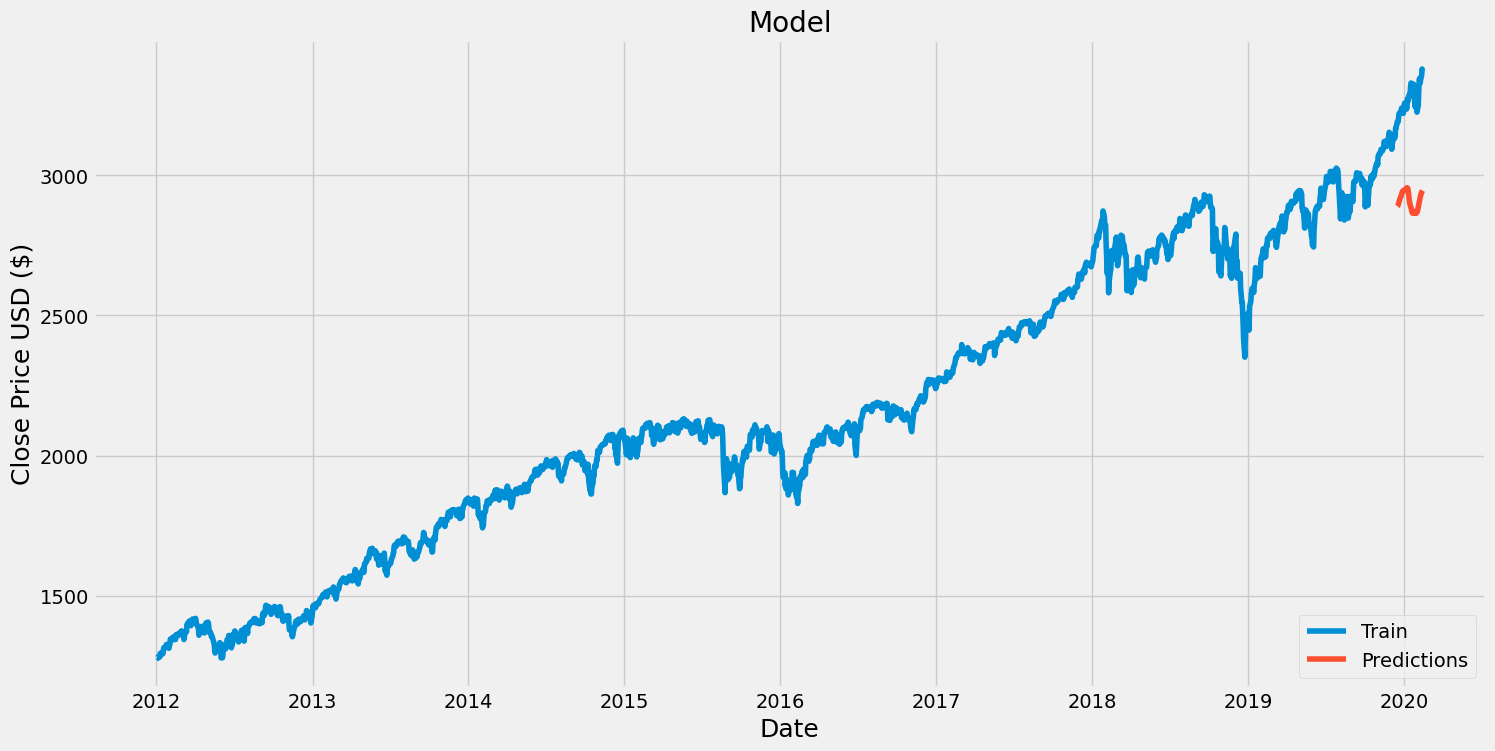

In [185]:
stock_price = yf.download('^GSPC', start='2012-01-01', end='2020-02-14')

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(stock_price['Close'])
plt.plot(PREDICTIONS_FUTURE['Close'])
plt.legend(['Train', 'Predictions'], loc='lower right')